## Get NEW Verification Data 0-100 meters

In [1]:
require(tidyverse, warn.conflicts = FALSE)
require(cowplot, warn.conflicts = FALSE)
require(scales, warn.conflicts = FALSE)

require(oce, warn.conflicts = FALSE)

Loading required package: tidyverse

Registered S3 methods overwritten by 'ggplot2':
  method         from 
  [.quosures     rlang
  c.quosures     rlang
  print.quosures rlang

Registered S3 method overwritten by 'rvest':
  method            from
  read_xml.response xml2

── Attaching packages ─────────────────────────────────────── tidyverse 1.2.1 ──

✔ ggplot2 3.1.1       ✔ purrr   0.3.2  
✔ tibble  2.1.1       ✔ dplyr   0.8.0.1
✔ tidyr   0.8.3       ✔ stringr 1.4.0  
✔ readr   1.3.1       ✔ forcats 0.4.0  

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Loading required package: cowplot


********************************************************

Note: As of version 1.0.0, cowplot does not change the

  default ggplot2 theme anymore. To recover the previous

  behavior, execute:
  theme_set(theme_cowplot())

********************************************************


Loadin

In [2]:
# Function to read specific verfication type from dataset

prepdataframe <- function(variable='', datasource='niskin'){
    if(datasource=='niskin'){
    DF <- read.csv("../../RegimeShiftNotebooks/DATA_processed/Master_Niskin_cleaned_2.csv")
    DF$date <- as.Date(DF$Date, format="%Y-%m-%d")
    DF$depth <- DF$Depth_real
    print(names(DF))
        
    VarDF <- DF %>%
      select(date, variable, depth) %>%
      gather(key='key',value = "value", -date, -depth)
    head(VarDF)
    }
    
    return(VarDF)
}


In [3]:
# integration functions (if necessary)

# adapt integration function from PINCKNEY
integrateJAYfunc <- function(x, y){
    N1 = length(y)
    area = 0
    
    for(j in 2:N1){
        area = area + (x[j] - x[j-1]) * (y[j] + y[j-1]) / 2
    }
    return(area)
}

intgrtJAY <- function(DFtest, reg, var){
    DF_int <- DFtest %>%
        group_by(date) %>%
        do(data.frame("value_int" = with(.,integrateJAYfunc(x=depth, y=value)), "reg" = reg , "var" = var)) %>%
        ungroup()
        
    return(DF_int)
}

In [4]:
# Interpolate
interpolateDF <- function(DF,func='oce-rr'){
    zz <- seq(0, 200, 1)
    
    if(func=='oce-rr'){
        IntDF <- DF %>%
            group_by(date) %>%
            do(data.frame(value_int = with(.,oceApprox(depth, value, zz, "rr")), depth = zz)) 
        }
    
    return(IntDF)
}

# take MEAN of concentrations at certain depth
meanTOdepth <- function(DF_int,type='fixed',depthFROM=0,depthTO=100){
    if(type=='MLD'){
        # read MLD and euphotic depth file
        MLD2EuZ <- read.csv("../MIXING/MLD2EuZ_2.csv")
        MLD2EuZ$date <- as.Date(MLD2EuZ$Date, format="%Y-%m-%d")

        merge_DF_mld <- merge(DF_int, MLD2EuZ, by="date")
        merge_DF_mld$depthdiff <- merge_DF_mld$MLD2015 - merge_DF_mld$depth
        
        DF_means <- merge_DF_mld %>%
            group_by(date) %>% # this groups it by the run number 
            filter(depthdiff > 0) %>% # only keep values above MLD
            summarize('mean'=mean(value_int, na.rm=T))
    }else{
        DF_means <- DF_int %>%
            group_by(date) %>% # this groups it by the run number 
            filter(depthFROM < depth & depth < depthTO) %>% # only keep values above the depth passed to function
            summarize('mean'=mean(value_int, na.rm=T))
        }
    return(DF_means)
}
###########################################################################################################################
plotRegimeSPLIT <- function(R1,R2,label){
    options(repr.plot.width=11, repr.plot.height=3)
    Plot_1 <- ggplot() + geom_point(data=R1,aes(x=dyear, y=mean, col='Regime 1'))+ #scale_y_continuous(trans = "reverse", limits = c(70,0), breaks=seq(70,0,-10))+
        geom_point(data=R2,aes(x=dyear, y=mean, col='Regime 2')) + 
        scale_x_date(date_breaks = "months", labels = date_format('%m'))+
        ylab(paste(label,'[µM]')) + xlab('Month of year') + labs(col='Regime')
    
    # plot boxplot of distribution over the year per group
    Plot_2 <- ggplot() + geom_boxplot(data=R1,aes(x=reorder(month,dyear), y=mean, col='Regime 1'))+ #scale_y_continuous(trans = "reverse", limits = c(70,0), breaks=seq(70,0,-10))+
        geom_boxplot(data=R2,aes(x=reorder(month,dyear), y=mean, col='Regime 2'), alpha=0.5)+ 
        scale_x_discrete(limits=c("01","02","03","04","05","06","07","08","09","10","11","12"))+
        #scale_x_continous(breaks = "months", labels = date_format('%m'))+
        ylab(paste(label,'[µM]')) + xlab('Month of year') + labs(col='Regime')
    
 
    options(repr.plot.width=11, repr.plot.height=8)
    meanR1 <- mean(R1$mean, na.rm=T)
    meanR2 <- mean(R2$mean, na.rm=T)
    cvR1 <- sd(R1$mean, na.rm=T)/mean(R1$mean, na.rm=T)
    cvR2 <- sd(R2$mean, na.rm=T)/mean(R2$mean, na.rm=T)
    stats <- ggdraw() + draw_label(sprintf(" R1: Mean = %f - CV = %f \nR2: Mean = %f - CV = %f", meanR1, cvR1, meanR2, cvR2))
    
    REGIMEplot <- plot_grid(Plot_1, Plot_2, stats, ncol = 1,labels = c("A", "B","stats"), rel_heights = c(1,1,0.2))
    
    return(REGIMEplot)
    }
    
plotRegimeFORCING <- function(R1,R2,label){        
    F1 <- R1 %>% 
        group_by(month) %>% 
        summarise(
            dyear = mean(dyear),
            mean_ = mean(mean, na.rm=T),
            median = median(mean, na.rm=T)
        )

    F2 <- R2 %>% 
        group_by(month) %>% 
        summarise(
            dyear = mean(dyear),
            mean_ = mean(mean, na.rm=T),
            median = median(mean, na.rm=T)
        )
    
    options(repr.plot.width=11, repr.plot.height=3)
    FORCINGplot <- ggplot() + geom_point(data=R1,aes(x=dyear, y=mean, col='Regime 1'))+ #scale_y_continuous(trans = 'reverse', limits = c(70,0), breaks=seq(70,0,-10))+
        geom_point(data=R2,aes(x=dyear, y=mean, col='Regime 2')) +
        geom_line(data=F1,aes(x=dyear, y=mean_, col='Regime 1'), linetype=2) +
        geom_line(data=F2,aes(x=dyear, y=mean_, col='Regime 2'), linetype=2) +
        geom_line(data=F1,aes(x=dyear, y=median, col='Regime 1'), linetype=1) +
        geom_line(data=F2,aes(x=dyear, y=median, col='Regime 2'), , linetype=1) +
        scale_x_date(date_breaks = 'months', labels = date_format('%m'))+
        ylab(paste(label,'[µM]')) + xlab('Month of year') + labs(col='Regime')
    
    return(FORCINGplot)
}
################################################################################################################################
# split MEANS of data by regimes, 
splitBYregimes <- function(DF_means, out='Plot_Forcing', label = '', spec = ''){
    # create day of year and month columsn for aggregate plotting
    DF_means$dyear <- as.Date(format(DF_means$date, format="%m-%d"),format="%m-%d")
    DF_means$month <- format(DF_means$date, format="%m")
    
    if(spec!=''){
        DF_means <- DF_means[DF$spec == spec,]
    }
    
    #split data into two regimes:
    R1 <- DF_means[!DF_means$date>as.Date('2000-10-30') & !DF_means$date<as.Date('1996-01-01'),]
    R2 <- DF_means[!DF_means$date<as.Date('2006-06-30') & !DF_means$date>as.Date('2010-12-31'),]
    
    R1ctDate <- as.POSIXlt(R1$date)
    R2ctDate <- as.POSIXlt(R2$date)

    R1yday <- R1ctDate$yday
    R2yday <- R2ctDate$yday
    
    # PLOT FUNCTION IS HERE:
    #######################
    if(out=='Plot_Regime'){
        PlotF <- plotRegimeSPLIT(R1, R2, label)
        return(PlotF)
    } else if(out=='Plot_Forcing'){
        PlotR <- plotRegimeFORCING(R1, R2, label)
        return(PlotR)
    } else if(out=='Dataframe'){
        R1_csv <- data.frame(Value = R1$mean, month = R1$month, yday = R1yday, reg = 1)
        R2_csv <- data.frame(Value = R2$mean, month = R2$month, yday = R2yday, reg = 2)
        RegComb <- rbind(R1_csv, R2_csv)
        return(RegComb)
    } else {'wrong out argument passed to splitBYregimes function'}
}

In [5]:
# filter depth below 100
# need concentrations, not integrated biomass
# also should make sure to do the correct comparison for model output! integrated vs integrated, and conc vs conc

## SILICATE

 [1] "X"                 "Cruise"            "Leg"              
 [4] "Day"               "Month"             "Year"             
 [7] "Depth_target"      "Depth_real"        "O2_ml_L"          
[10] "O2_umol_kg"        "SiOH4_Cumana"      "X..PO4_Cumana"    
[13] "NO3_Cumana"        "NH4."              "NO2."             
[16] "NO3NO2."           "PO4"               "SiOH4"            
[19] "pH"                "Alkalinity"        "TCO2"             
[22] "fCO2"              "Salinity_bott"     "Salinity_bottcorr"
[25] "Salinity_ctd"      "Temp_ctd"          "Sigma.t_ctd"      
[28] "TPP"               "PIP"               "POC"              
[31] "PN"                "C.N.part."         "POC.1"            
[34] "PN.1"              "DON_USF"           "DOP_USF"          
[37] "DOC"               "TOC"               "PriPro"           
[40] "Chl"               "Phaeo"             "Date"             
[43] "DateString"        "yday"              "date"             
[46] "depth"            


Warning message:
“Removed 23 rows containing missing values (geom_point).”
Warning message:
“Removed 1 rows containing missing values (geom_point).”
Warning message:
“Removed 23 rows containing non-finite values (stat_boxplot).”
Warning message:
“Removed 1 rows containing non-finite values (stat_boxplot).”
Warning message:
“Removed 23 rows containing missing values (geom_point).”
Warning message:
“Removed 1 rows containing missing values (geom_point).”


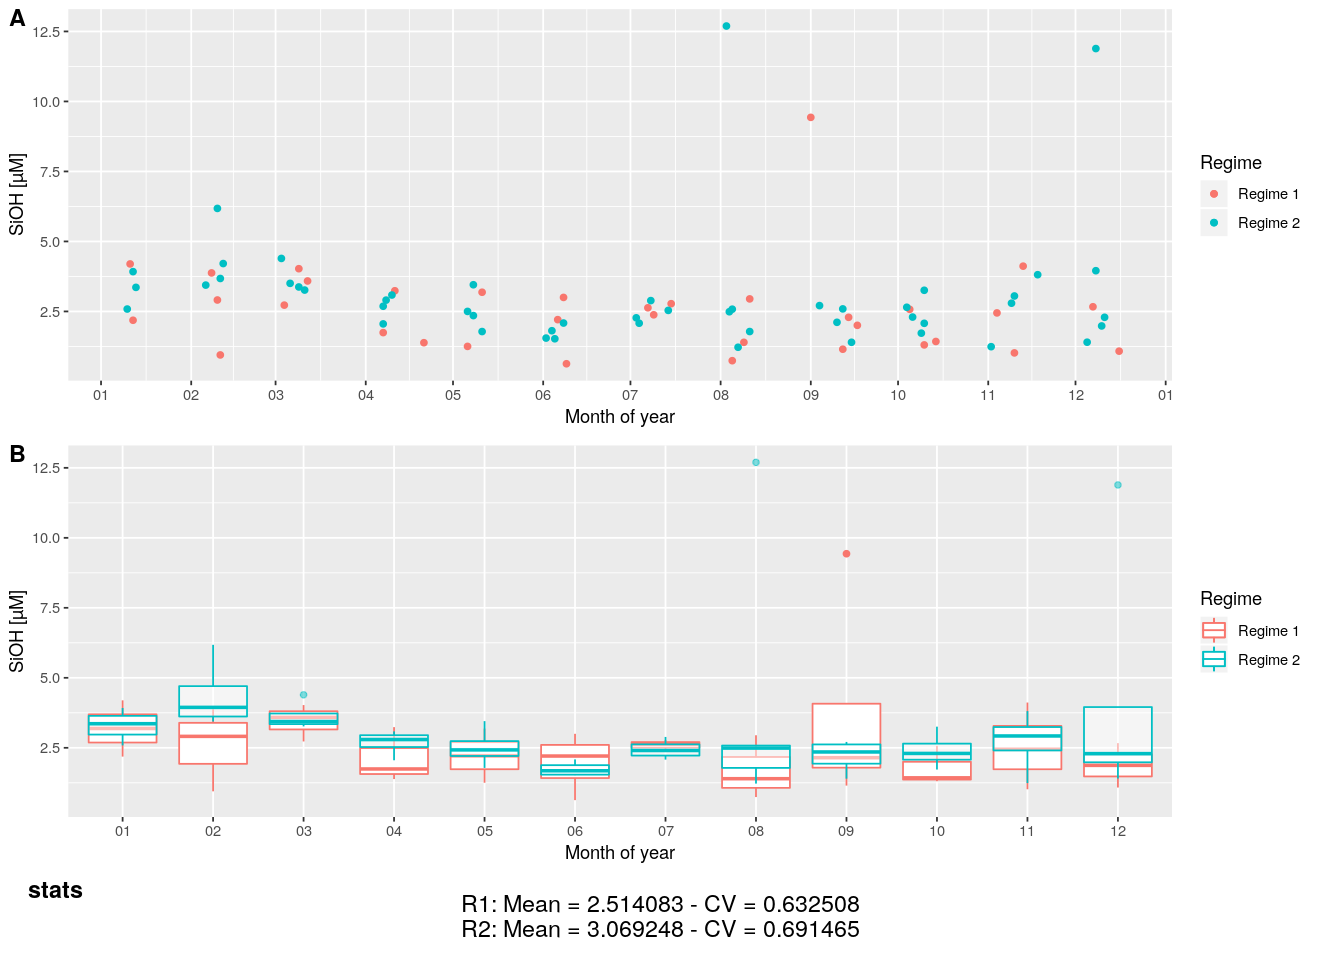

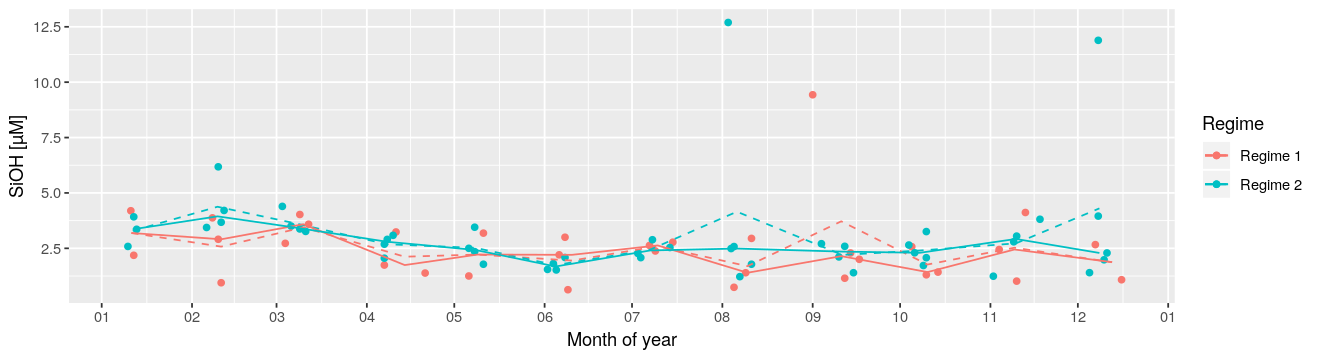

In [6]:
SiOH <- prepdataframe('SiOH4')
#head(SiOH)

##############################
SiOH_int <- interpolateDF(SiOH)
#options(repr.plot.width=11, repr.plot.height=3)
#ggplot(SiOH_int, aes(x=date,y=-depth,col=value_int))+geom_point()

##############################
SiOH_mean <- meanTOdepth(SiOH_int, type='fixed')
#ggplot() + geom_point(data=SiOH_mean, aes(x=date,y=mean))

##############################
SiOH_atDEPTH <- meanTOdepth(SiOH_int, type='fixed', depthFROM = 100, depthTO = 150)
#ggplot() + geom_point(data=SiOH_atDEPTH, aes(x=date,y=mean))

##############################
# split by regimes
splitBYregimes(SiOH_mean, out="Plot_Regime", label='SiOH')
splitBYregimes(SiOH_mean, out="Plot_Forcing", label='SiOH')

SiOH_out <- splitBYregimes(SiOH_mean, out="Dataframe")
SiOH_Deep_out <- splitBYregimes(SiOH_atDEPTH, out="Dataframe")

## NITROGEN

 [1] "X"                 "Cruise"            "Leg"              
 [4] "Day"               "Month"             "Year"             
 [7] "Depth_target"      "Depth_real"        "O2_ml_L"          
[10] "O2_umol_kg"        "SiOH4_Cumana"      "X..PO4_Cumana"    
[13] "NO3_Cumana"        "NH4."              "NO2."             
[16] "NO3NO2."           "PO4"               "SiOH4"            
[19] "pH"                "Alkalinity"        "TCO2"             
[22] "fCO2"              "Salinity_bott"     "Salinity_bottcorr"
[25] "Salinity_ctd"      "Temp_ctd"          "Sigma.t_ctd"      
[28] "TPP"               "PIP"               "POC"              
[31] "PN"                "C.N.part."         "POC.1"            
[34] "PN.1"              "DON_USF"           "DOP_USF"          
[37] "DOC"               "TOC"               "PriPro"           
[40] "Chl"               "Phaeo"             "Date"             
[43] "DateString"        "yday"              "date"             
[46] "depth"            


Warning message:
“Removed 23 rows containing missing values (geom_point).”Warning message:
“Removed 23 rows containing non-finite values (stat_boxplot).”Warning message:
“Removed 23 rows containing missing values (geom_point).”

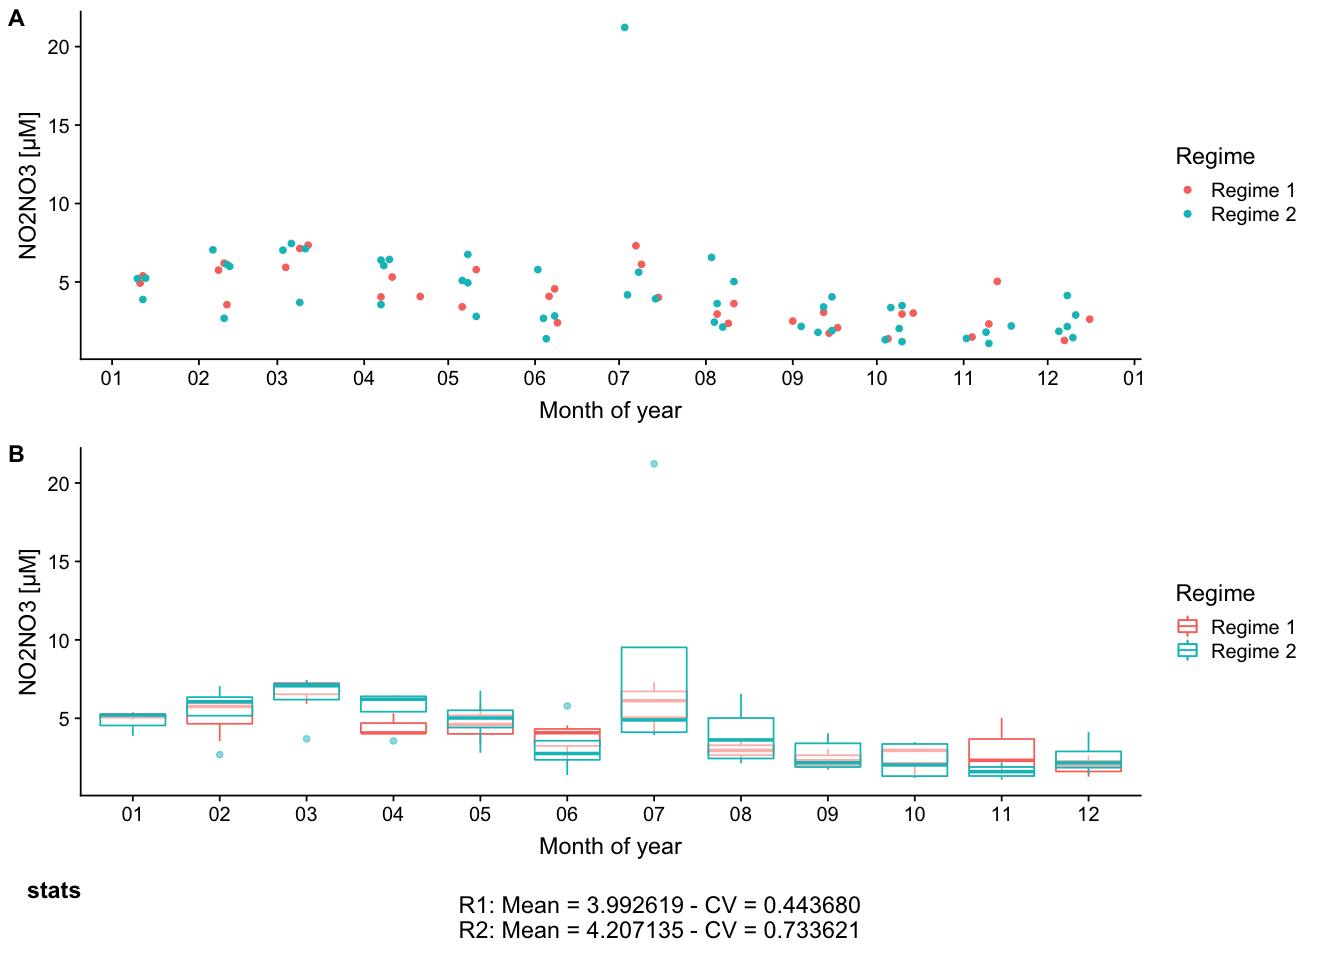

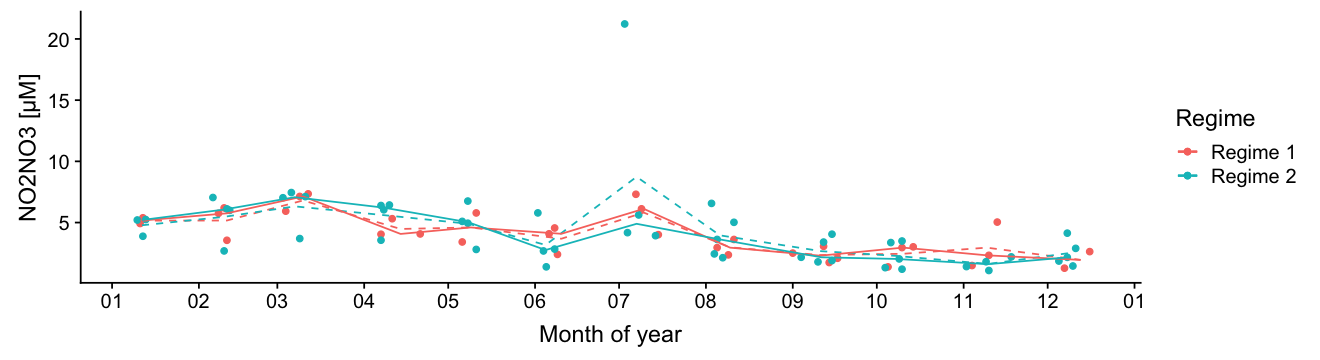

In [8]:
NO2NO3 <- prepdataframe('NO3NO2.')
#head(SiOH)

##############################
NO2NO3_int <- interpolateDF(NO2NO3)
#options(repr.plot.width=11, repr.plot.height=3)
#ggplot(SiOH_int, aes(x=date,y=-depth,col=value_int))+geom_point()

##############################
NO2NO3_mean <- meanTOdepth(NO2NO3_int, type='fixed')
#ggplot() + geom_point(data=SiOH_mean, aes(x=date,y=mean))

##############################
NO2NO3_atDEPTH <- meanTOdepth(NO2NO3_int, type='fixed', depthFROM = 100, depthTO = 150)
#ggplot() + geom_point(data=SiOH_atDEPTH, aes(x=date,y=mean))

##############################
# split by regimes
splitBYregimes(NO2NO3_mean, out="Plot_Regime", label='NO2NO3')
splitBYregimes(NO2NO3_mean, out="Plot_Forcing", label='NO2NO3')

NO2NO3_out <- splitBYregimes(NO2NO3_mean, out="Dataframe")
NO2NO3_Deep_out <- splitBYregimes(NO2NO3_atDEPTH, out="Dataframe")

## OTHER VARIABLES

# What else can I use: 
- 'PN' --- potenitally use particulate nitrogen as proxy for detritus!
- potentially PO4, NH4., NO2. also interesting
- 

 [1] "X"                 "Cruise"            "Leg"              
 [4] "Day"               "Month"             "Year"             
 [7] "Depth_target"      "Depth_real"        "O2_ml_L"          
[10] "O2_umol_kg"        "SiOH4_Cumana"      "X..PO4_Cumana"    
[13] "NO3_Cumana"        "NH4."              "NO2."             
[16] "NO3NO2."           "PO4"               "SiOH4"            
[19] "pH"                "Alkalinity"        "TCO2"             
[22] "fCO2"              "Salinity_bott"     "Salinity_bottcorr"
[25] "Salinity_ctd"      "Temp_ctd"          "Sigma.t_ctd"      
[28] "TPP"               "PIP"               "POC"              
[31] "PN"                "C.N.part."         "POC.1"            
[34] "PN.1"              "DON_USF"           "DOP_USF"          
[37] "DOC"               "TOC"               "PriPro"           
[40] "Chl"               "Phaeo"             "Date"             
[43] "DateString"        "yday"              "date"             
[46] "depth"            


Warning message:
“Removed 23 rows containing missing values (geom_point).”
Warning message:
“Removed 23 rows containing non-finite values (stat_boxplot).”
Warning message:
“Removed 23 rows containing missing values (geom_point).”


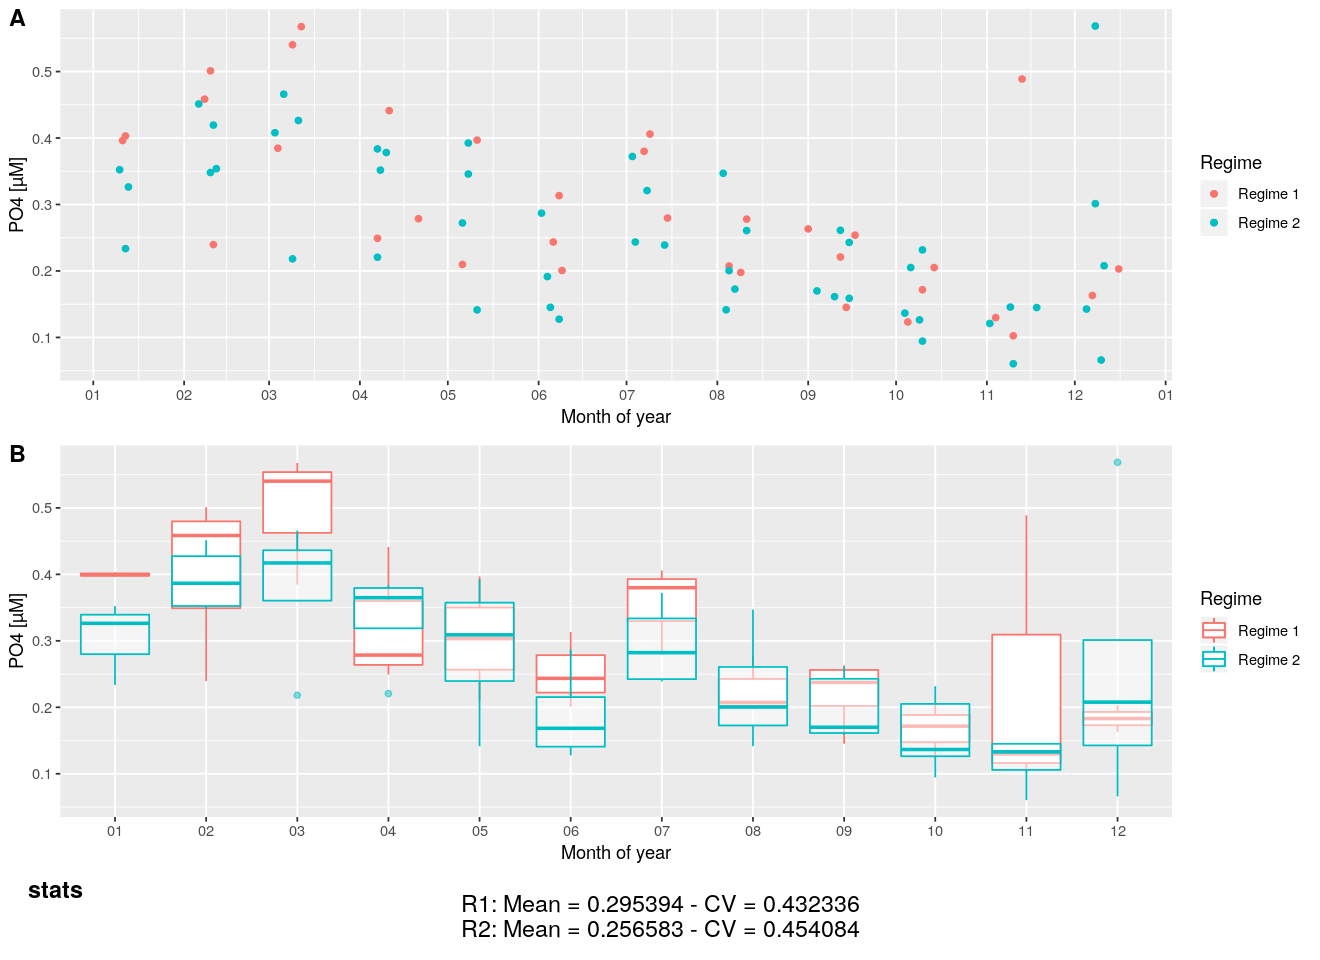

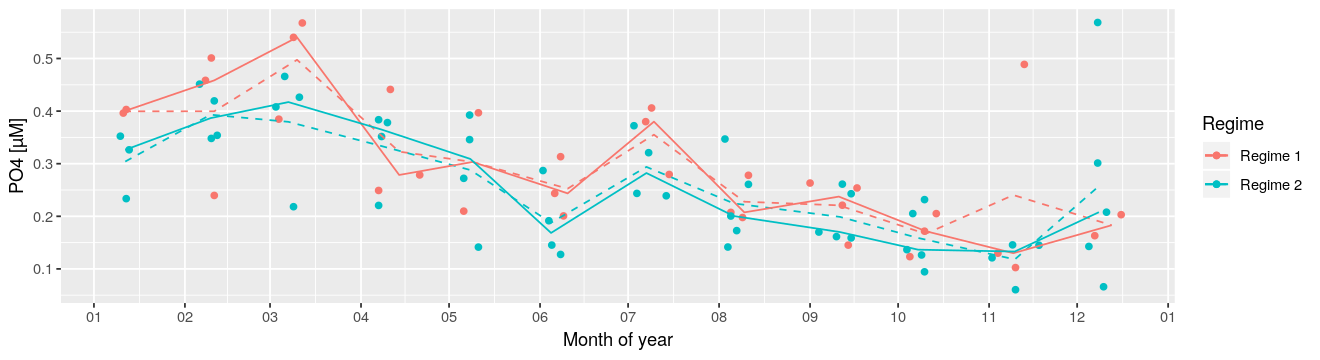

In [9]:
PO4 <- prepdataframe('PO4')
#head(SiOH)

##############################
PO4_int <- interpolateDF(PO4)
#options(repr.plot.width=11, repr.plot.height=3)
#ggplot(SiOH_int, aes(x=date,y=-depth,col=value_int))+geom_point()

##############################
PO4_mean <- meanTOdepth(PO4_int, type='fixed')
#ggplot() + geom_point(data=SiOH_mean, aes(x=date,y=mean))

##############################
PO4_atDEPTH <- meanTOdepth(PO4_int, type='fixed', depthFROM = 100, depthTO = 150)
#ggplot() + geom_point(data=SiOH_atDEPTH, aes(x=date,y=mean))

##############################
# split by regimes
splitBYregimes(PO4_mean, out="Plot_Regime", label='PO4')
splitBYregimes(PO4_mean, out="Plot_Forcing", label='PO4')

PO4_out <- splitBYregimes(PO4_mean, out="Dataframe")

PO4_Deep_out <- splitBYregimes(PO4_atDEPTH, out="Dataframe")

In [8]:

# PN_out
PO4_r1 <- PO4_out[PO4_out$reg == 1,]
PO4_r2 <- PO4_out[PO4_out$reg == 2,]
# Write CSV in R
write.csv(PO4_r1, file = "NewVerifDATA/PO4_r1.csv")
write.csv(PO4_r2, file = "NewVerifDATA/PO4_r2.csv")

 [1] "X"                 "Cruise"            "Leg"              
 [4] "Day"               "Month"             "Year"             
 [7] "Depth_target"      "Depth_real"        "O2_ml_L"          
[10] "O2_umol_kg"        "SiOH4_Cumana"      "X..PO4_Cumana"    
[13] "NO3_Cumana"        "NH4."              "NO2."             
[16] "NO3NO2."           "PO4"               "SiOH4"            
[19] "pH"                "Alkalinity"        "TCO2"             
[22] "fCO2"              "Salinity_bott"     "Salinity_bottcorr"
[25] "Salinity_ctd"      "Temp_ctd"          "Sigma.t_ctd"      
[28] "TPP"               "PIP"               "POC"              
[31] "PN"                "C.N.part."         "POC.1"            
[34] "PN.1"              "DON_USF"           "DOP_USF"          
[37] "DOC"               "TOC"               "PriPro"           
[40] "Chl"               "Phaeo"             "Date"             
[43] "DateString"        "yday"              "date"             
[46] "depth"            


Warning message:
“Removed 7 rows containing missing values (geom_point).”Warning message:
“Removed 7 rows containing non-finite values (stat_boxplot).”Warning message:
“Removed 7 rows containing missing values (geom_point).”

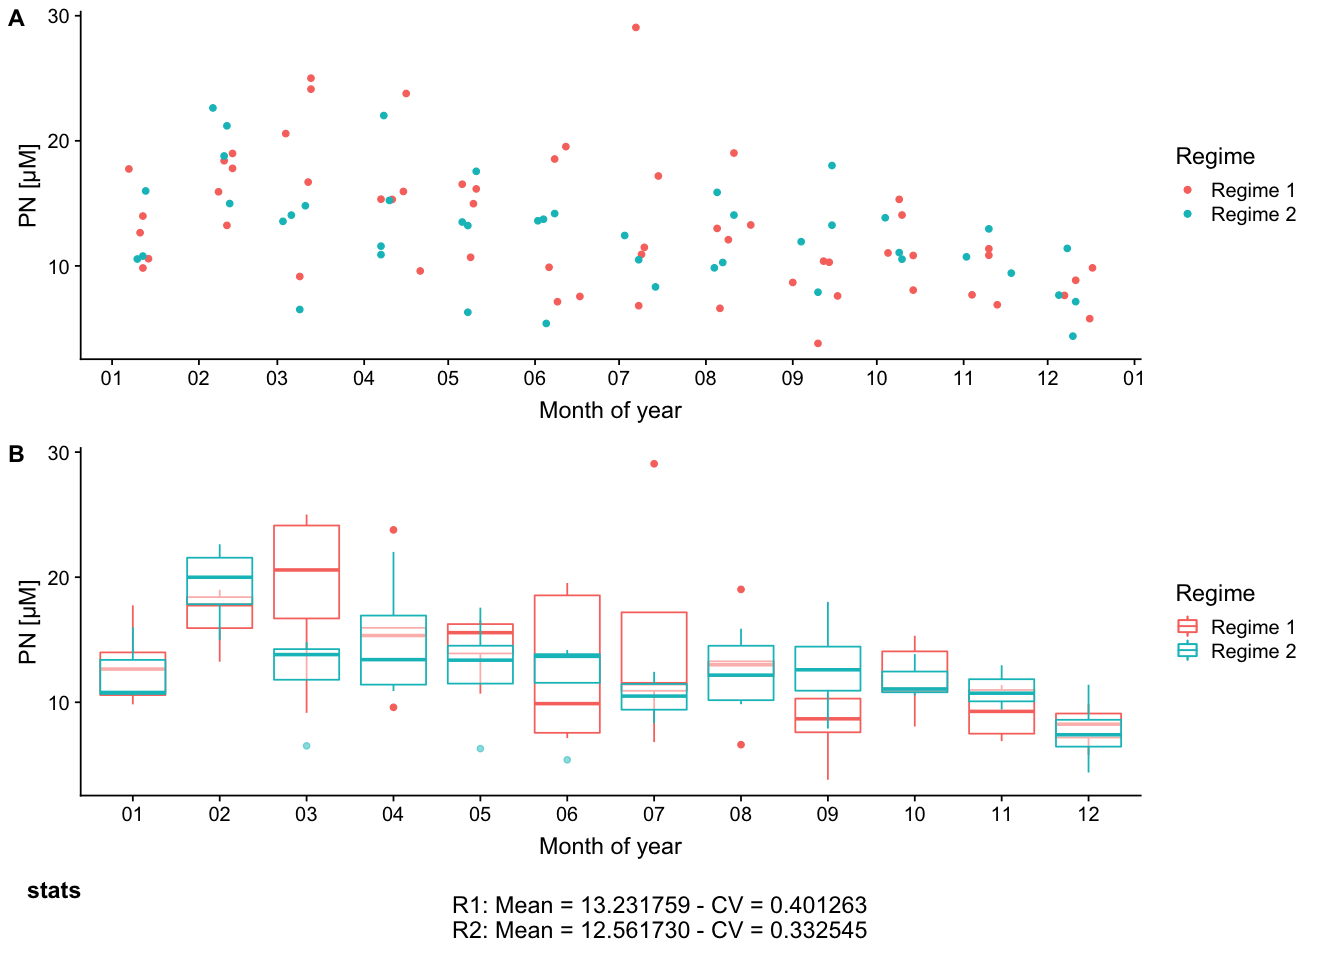

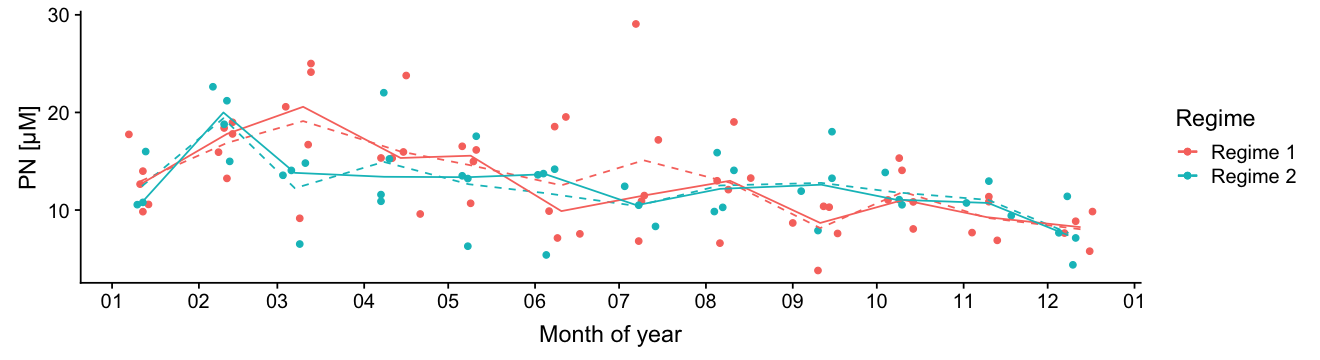

In [5]:
PN <- prepdataframe('PN.1')
#head(SiOH)

##############################
PN_int <- interpolateDF(PN)
#options(repr.plot.width=11, repr.plot.height=3)
#ggplot(SiOH_int, aes(x=date,y=-depth,col=value_int))+geom_point()

##############################
PN_mean <- meanTOdepth(PN_int, type='fixed')
#ggplot() + geom_point(data=SiOH_mean, aes(x=date,y=mean))

##############################
PN_atDEPTH <- meanTOdepth(PN_int, type='fixed', depthFROM = 100, depthTO = 150)
#ggplot() + geom_point(data=SiOH_atDEPTH, aes(x=date,y=mean))

##############################
# split by regimes
splitBYregimes(PN_mean, out="Plot_Regime", label='PN')
splitBYregimes(PN_mean, out="Plot_Forcing", label='PN')

PN_out <- splitBYregimes(PN_mean, out="Dataframe")

In [10]:
mean(PN_out$Value, na.rm=T)

[1] 12.93987

In [7]:

# PN_out
PN_r1 <- PN_out[PN_out$reg == 1,]
PN_r2 <- PN_out[PN_out$reg == 2,]
# Write CSV in R
write.csv(PN_r1, file = "NewVerifDATA/PN_r1.csv")
write.csv(PN_r2, file = "NewVerifDATA/PN_r2.csv")

# export data!

In [183]:
# SiOH_out
SiOH_r1 <- SiOH_out[SiOH_out$reg == 1,]
SiOH_r2 <- SiOH_out[SiOH_out$reg == 2,]
# Write CSV in R
write.csv(SiOH_r1, file = "NewVerifDATA/SiOH_r1.csv")
write.csv(SiOH_r2, file = "NewVerifDATA/SiOH_r2.csv")

# NO2NO3_out
NO2NO3_r1 <- NO2NO3_out[NO2NO3_out$reg == 1,]
NO2NO3_r2 <- NO2NO3_out[NO2NO3_out$reg == 2,]
# Write CSV in R
write.csv(NO2NO3_r1, file = "NewVerifDATA/NO2NO3_r1.csv")
write.csv(NO2NO3_r2, file = "NewVerifDATA/NO2NO3_r2.csv")

# PN_out
PN_r1 <- PN_out[PN_out$reg == 1,]
PN_r2 <- PN_out[PN_out$reg == 2,]
# Write CSV in R
write.csv(PN_r1, file = "NewVerifDATA/PN_r1.csv")
write.csv(PN_r2, file = "NewVerifDATA/PN_r2.csv")

In [9]:
# SiOH_out
SiOH_Deep_r1 <- SiOH_Deep_out[SiOH_Deep_out$reg == 1,]
SiOH_Deep_r2 <- SiOH_Deep_out[SiOH_Deep_out$reg == 2,]
# Write CSV in R
write.csv(SiOH_Deep_r1, file = "NewVerifDATA/DeepSiOH_r1.csv")
write.csv(SiOH_Deep_r2, file = "NewVerifDATA/DeepSiOH_r2.csv")

# NO2NO3_out
NO2NO3_Deep_r1 <- NO2NO3_Deep_out[NO2NO3_Deep_out$reg == 1,]
NO2NO3_Deep_r2 <- NO2NO3_Deep_out[NO2NO3_Deep_out$reg == 2,]
# Write CSV in R
write.csv(NO2NO3_Deep_r1, file = "NewVerifDATA/DeepNO2NO3_r1.csv")
write.csv(NO2NO3_Deep_r2, file = "NewVerifDATA/DeepNO2NO3_r2.csv")


In [10]:
# NO2NO3_out
PO4_Deep_r1 <- PO4_Deep_out[PO4_Deep_out$reg == 1,]
PO4_Deep_r2 <- PO4_Deep_out[PO4_Deep_out$reg == 2,]
# Write CSV in R
write.csv(PO4_Deep_r1, file = "NewVerifDATA/DeepPO4_r1.csv")
write.csv(PO4_Deep_r2, file = "NewVerifDATA/DeepPO4_r2.csv")

# HPLC DATA ANALYSIS

# export data!

In [11]:
DF <- read.csv("../../RegimeShiftNotebooks/DATA_processed/NewComb_FT_all_PinckneyHPLC.csv")
DF$date <- as.Date(DF$date, format="%Y-%m-%d")
DF$mean <- DF$value_int
head(levels(DF$spec))

[1] "Cyanobacteria"       "Diatoms_Hapto1"      "Dinoflagellates"    
[4] "Haptophytes"         "Others (Pr,Cry,Chl)"

In [180]:
DF <- read.csv("../../RegimeShiftNotebooks/DATA_processed/NewComb_FT_all_PinckneyHPLC.csv")
DF$date <- as.Date(DF$date, format="%Y-%m-%d")
DF$mean <- DF$value_int
head(levels(DF$spec))

Diatoms_Hapto1 <- splitBYregimes(DF, out = 'Dataframe', spec = 'Diatoms_Hapto1', label = 'Diatoms')
Diatoms_r1 <- Diatoms_Hapto1[Diatoms_Hapto1$reg == 1,]
Diatoms_r2 <- Diatoms_Hapto1[Diatoms_Hapto1$reg == 2,]
# Write CSV in R
write.csv(Diatoms_r1, file = "NewVerifDATA/Diatoms_r1.csv")
write.csv(Diatoms_r2, file = "NewVerifDATA/Diatoms_r2.csv")

Cyanobacteria <- splitBYregimes(DF, out = 'Dataframe', spec = 'Cyanobacteria', label = 'Diatoms')
Cyano_r1 <- Cyanobacteria[Cyanobacteria$reg == 1,]
Cyano_r2 <- Cyanobacteria[Cyanobacteria$reg == 2,]
# Write CSV in R
write.csv(Cyano_r1, file = "NewVerifDATA/Cyano_r1.csv")
write.csv(Cyano_r2, file = "NewVerifDATA/Cyano_r2.csv")

Dinoflagellates <- splitBYregimes(DF, out = 'Dataframe', spec = 'Dinoflagellates', label = 'Diatoms')
Dino_r1 <- Dinoflagellates[Dinoflagellates$reg == 1,]
Dino_r2 <- Dinoflagellates[Dinoflagellates$reg == 2,]
# Write CSV in R
write.csv(Dino_r1, file = "NewVerifDATA/Dino_r1.csv")
write.csv(Dino_r2, file = "NewVerifDATA/Dino_r2.csv")

Haptophytes <- splitBYregimes(DF, out = 'Dataframe', spec = 'Haptophytes', label = 'Diatoms')
Hapto_r1 <- Haptophytes[Haptophytes$reg == 1,]
Hapto_r2 <- Haptophytes[Haptophytes$reg == 2,]
# Write CSV in R
write.csv(Hapto_r1, file = "NewVerifDATA/Hapto_r1.csv")
write.csv(Hapto_r2, file = "NewVerifDATA/Hapto_r2.csv")

Others <- splitBYregimes(DF, out = 'Dataframe', spec = 'Others (Pr,Cry,Chl)', label = 'Diatoms')
Others_r1 <- Others[Others$reg == 1,]
Others_r2 <- Others[Others$reg == 2,]
# Write CSV in R
write.csv(Others_r1, file = "NewVerifDATA/Others_r1.csv")
write.csv(Others_r2, file = "NewVerifDATA/Others_r2.csv")

[1] "Cyanobacteria"       "Diatoms_Hapto1"      "Dinoflagellates"    
[4] "Haptophytes"         "Others (Pr,Cry,Chl)"